# Імпортування модулів, класів та функцій

In [17]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV, train_test_split

# Заповнення ДатаФрейму

In [18]:
def rename_column(dataframe: pd.DataFrame, old_column_name: str, new_column_name: str) -> None:
    dataframe = dataframe.rename(columns = {old_column_name: new_column_name}, inplace = True)


def drop_column(dataframe: pd.DataFrame, column_name: str) -> None:
    dataframe = dataframe.drop(columns = [column_name], inplace = True)


def replace_column_str(dataframe: pd.DataFrame, column_name: str, old_value: str, new_value: str) -> None:
    dataframe[column_name] = dataframe[column_name].replace(old_value, new_value, regex = True)


def convert_str_datetime(dataframe: pd.DataFrame, column_name: str) -> None:
    dataframe[column_name] = pd.to_datetime(dataframe[column_name])


sneakers_data = pd.read_csv("sneakers2023.csv", sep = ',', encoding = "utf-8")
sneakers_data.drop_duplicates(subset = "item", keep = False, inplace = True)

drop_column(sneakers_data, "lastSale")
drop_column(sneakers_data, "Unnamed: 0")
drop_column(sneakers_data, "pricePremium")
rename_column(sneakers_data, "brand", "Brand")
rename_column(sneakers_data, "item", "Sneaker Name")
rename_column(sneakers_data, "retail", "Retail Price")
rename_column(sneakers_data, "release", "Release Date")
rename_column(sneakers_data, "lowestAsk", "Lowest Ask")
rename_column(sneakers_data, "volatility", "Volatility")
rename_column(sneakers_data, "highestBid", "Highest Bid")
rename_column(sneakers_data, "annualLow", "Annual Lowest")
rename_column(sneakers_data, "annualHigh", "Annual Highest")
rename_column(sneakers_data, "numberOfAsks", "Number Of Asks")
rename_column(sneakers_data, "numberOfBids", "Number Of Bids")
rename_column(sneakers_data, "deadstockSold", "Deadstock Sold")
rename_column(sneakers_data, "salesThisPeriod", "Sold This Year")
rename_column(sneakers_data, "changePercentage", "Change Percentage")
rename_column(sneakers_data, "averageDeadstockPrice", "Average Deadstock Price")
replace_column_str(sneakers_data, "Brand", "Asics", "ASICS")
convert_str_datetime(sneakers_data, "Release Date")

mean_retail_price = sneakers_data.groupby("Brand")["Retail Price"].transform("mean")
sneakers_data["Retail Price"].mask(sneakers_data["Retail Price"] == 0, mean_retail_price, inplace = True)

sneakers_data["Retro"] = np.where(sneakers_data["Sneaker Name"].str.contains("Retro"), 1, 0)
sneakers_data["OG"] = np.where(sneakers_data["Sneaker Name"].str.contains("Retro"), 0, 1)

print(sneakers_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Sneaker Name             1338 non-null   object        
 1   Brand                    1338 non-null   object        
 2   Retail Price             1338 non-null   float64       
 3   Release Date             1263 non-null   datetime64[ns]
 4   Lowest Ask               1338 non-null   int64         
 5   Number Of Asks           1338 non-null   int64         
 6   Sold This Year           1338 non-null   int64         
 7   Highest Bid              1338 non-null   int64         
 8   Number Of Bids           1338 non-null   int64         
 9   Annual Highest           1338 non-null   int64         
 10  Annual Lowest            1338 non-null   int64         
 11  Volatility               1338 non-null   float64       
 12  Deadstock Sold           1338 non-

# Матриця кореляції

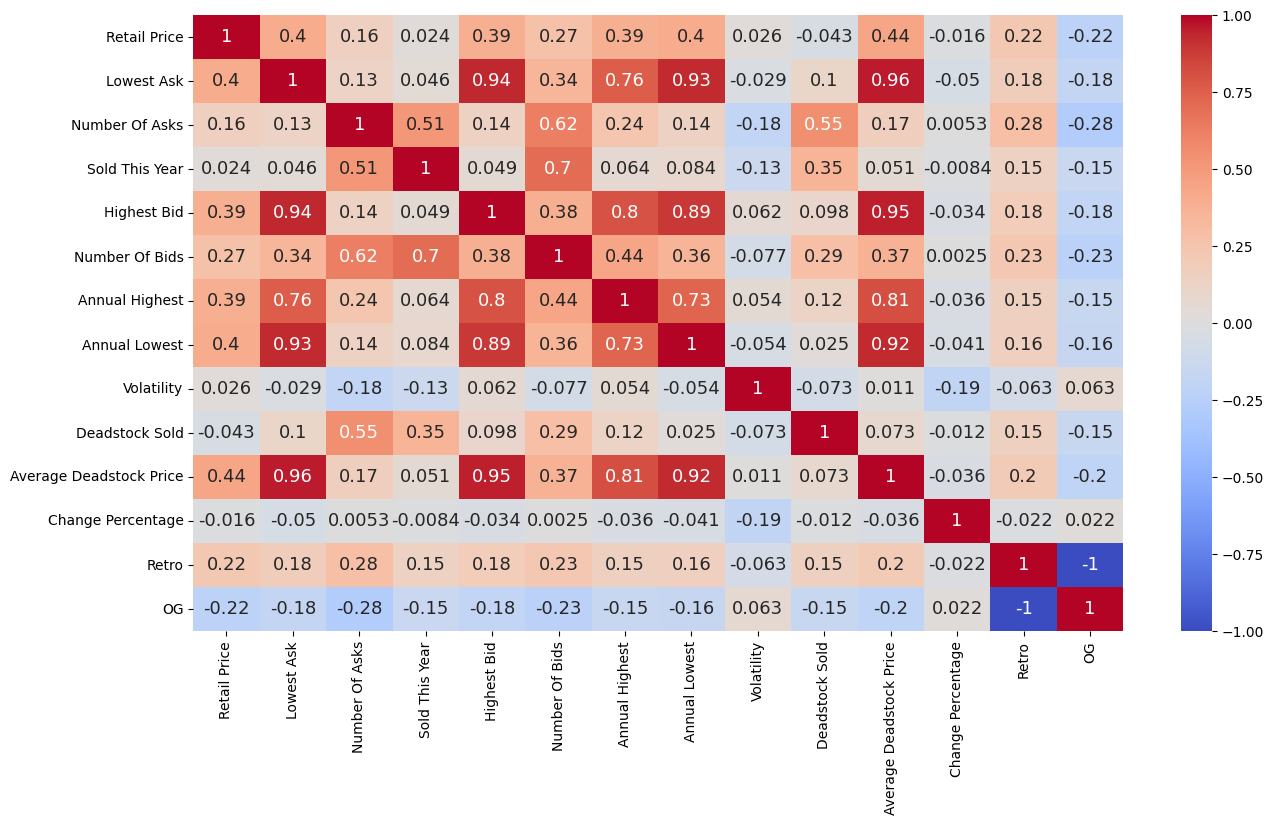

In [19]:
fig, axis = plt.subplots(figsize = (15, 8))
sns.heatmap(sneakers_data.corr(numeric_only = True), ax = axis, annot = True, cmap = "coolwarm", annot_kws = {"fontsize": 13})
plt.show()

# Розподілення Annual Highest

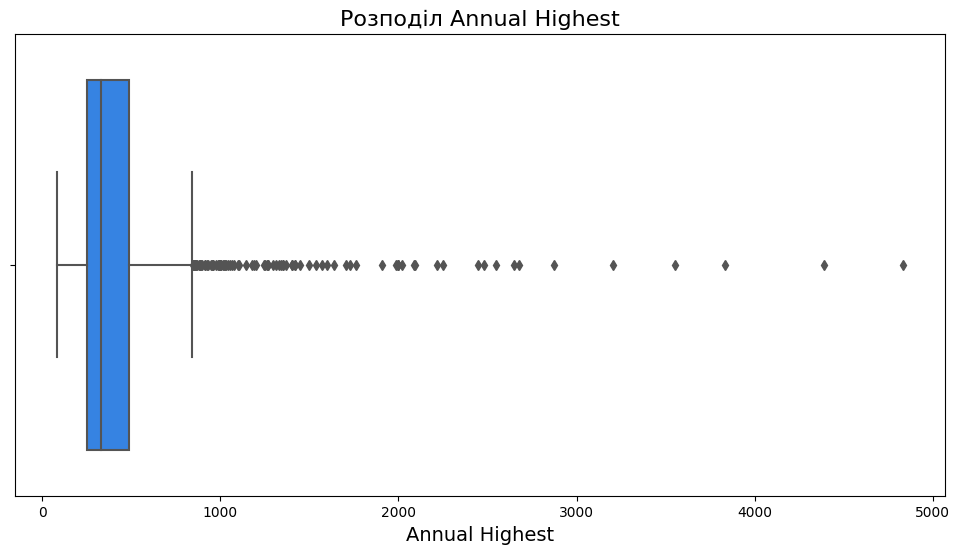

In [20]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.boxplot(x = sneakers_data["Annual Highest"], color = (0.1, 0.5, 1.0))
plt.xlabel("Annual Highest", fontsize = 14)
plt.title("Розподіл Annual Highest", fontsize = 16)
plt.show()

# Порівняння середнього арифметичного Annual Highest

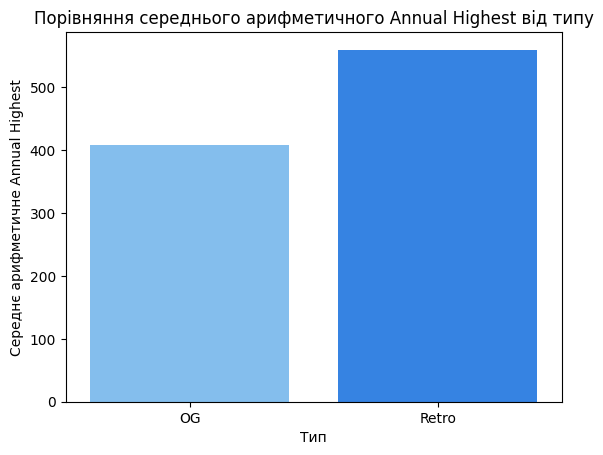

In [21]:
mean_data = pd.DataFrame({"Type": ["OG", "Retro"], "Mean": [sneakers_data.loc[sneakers_data["OG"] == 1, "Annual Highest"].mean(), sneakers_data.loc[sneakers_data["Retro"] == 1, "Annual Highest"].mean()]})
sns.barplot(x = "Type", y = "Mean", data = mean_data, palette = [(0.45, 0.75, 1.0), (0.1, 0.5, 1.0)])
plt.xlabel("Тип")
plt.ylabel("Середнє арифметичне Annual Highest")
plt.title("Порівняння середнього арифметичного Annual Highest від типу")
plt.show()

# Гістограма Annual Highest по Брендах

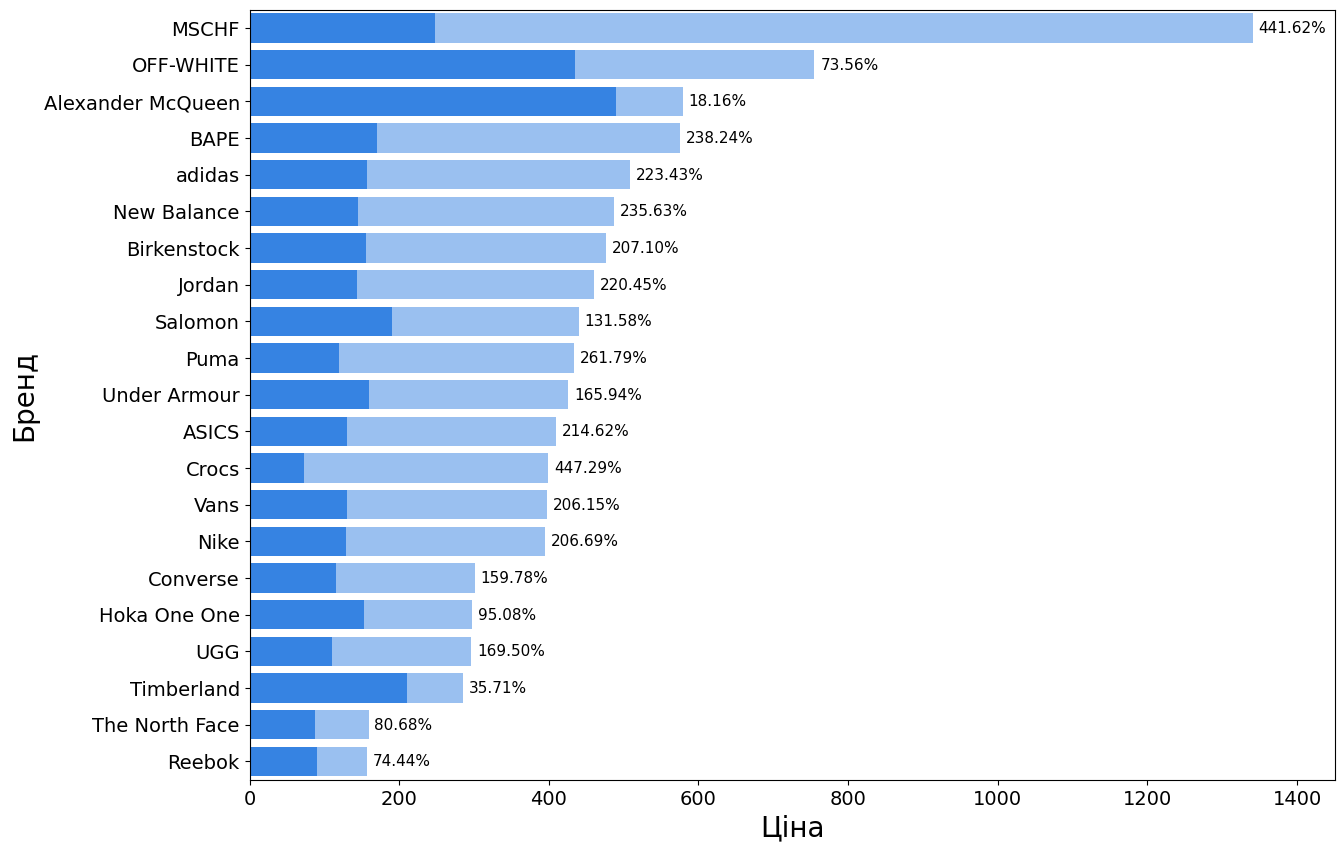

In [22]:
avg_deadstock_price_data = sneakers_data.groupby("Brand")["Annual Highest"].mean().reset_index()
avg_retail_price_data = sneakers_data.groupby("Brand")["Retail Price"].mean().reset_index()
merged = pd.merge(avg_deadstock_price_data, avg_retail_price_data, on = "Brand")
merged["Percentage Difference"] = ((merged["Annual Highest"] - merged["Retail Price"]) / merged["Retail Price"]) * 100
merged = merged.sort_values(by = "Annual Highest", ascending = False).reset_index(drop = True)

fig, ax = plt.subplots(figsize = (14, 10))
ax = sns.barplot(x = "Annual Highest", y = "Brand", data = merged, color = (0.1, 0.5, 1.0), alpha = 0.5)
ax = sns.barplot(x = "Retail Price", y = "Brand", data = merged, color = (0.1, 0.5, 1.0), alpha = 1.0)

for index, row in merged.iterrows():
    ax.text(row["Annual Highest"] + 8, index, f"{row['Percentage Difference']:.2f}%", fontsize = 11, va = "center")

plt.xlim(0, 1450)
plt.xlabel("Ціна", fontsize = 20)
plt.ylabel("Бренд", fontsize = 20)
plt.tick_params(labelsize = 14)

# Гістограма різниці по Брендах у порядку спадання

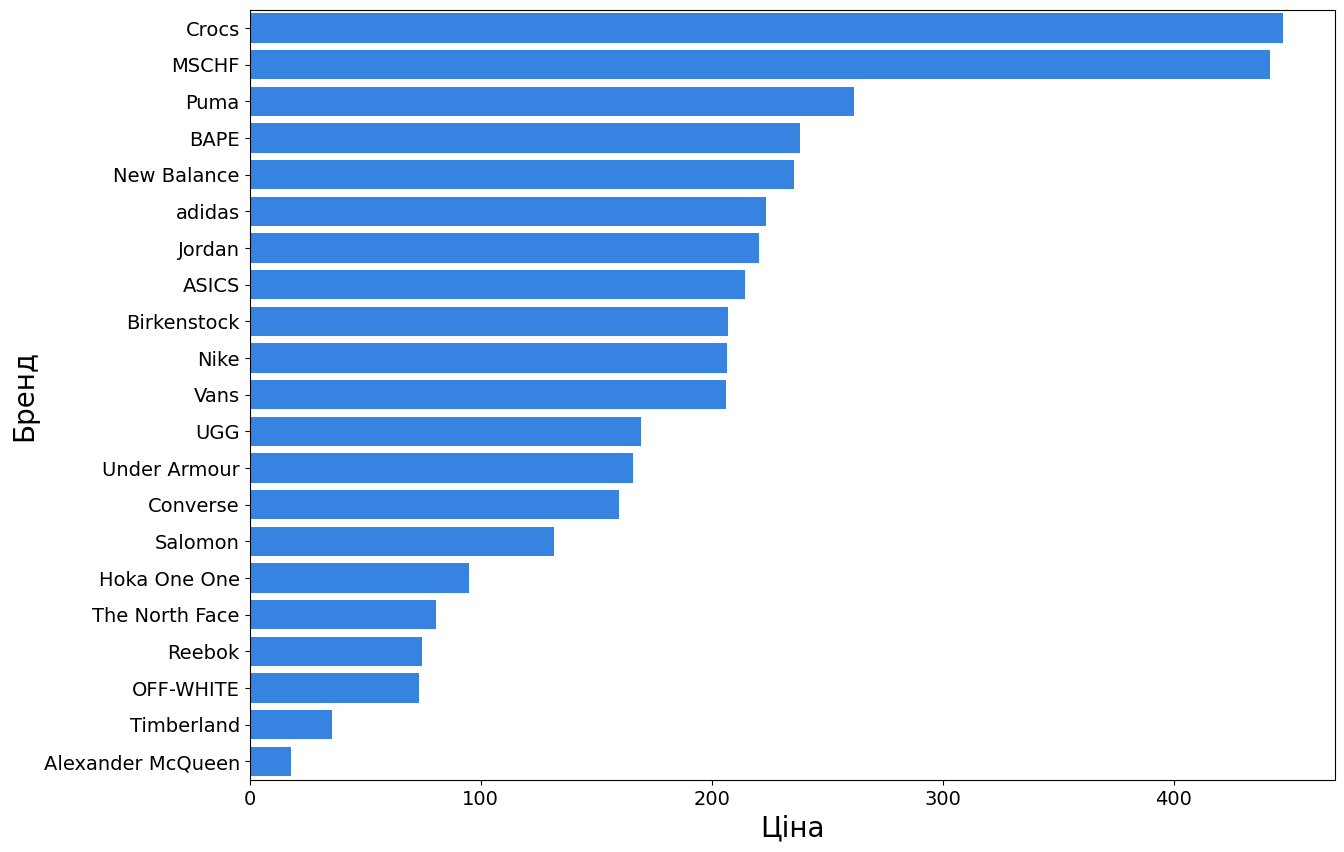

In [23]:
merged = merged.sort_values(by = "Percentage Difference", ascending = False).reset_index(drop = True)
fig, ax = plt.subplots(figsize = (14, 10))
ax = sns.barplot(x = "Percentage Difference", y = "Brand", data = merged, color = (0.1, 0.5, 1.0), alpha = 1.0)
plt.xlabel("Ціна", fontsize = 20)
plt.ylabel("Бренд", fontsize = 20)
plt.tick_params(labelsize = 14)

# Підготовка даних до інтелектуального аналізу

In [24]:
sneakers_data = pd.concat([sneakers_data, pd.get_dummies(sneakers_data["Brand"])], axis = 1)
x = sneakers_data.drop(columns = ["Sneaker Name", "Brand", "Release Date", "Change Percentage", "Volatility", "Sold This Year", "OG", "Annual Highest"], axis = 1)
y = sneakers_data["Annual Highest"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, train_size = 0.8, random_state = 0)
results = list()

# Допоміжні функції

In [25]:
warnings.filterwarnings("ignore", category = ConvergenceWarning)

def build_distribution_plot(model, x_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    plt.figure(figsize = (8, 7))
    sns.kdeplot(y_test, color = (0.9, 0.1, 0.1), label = "Справжні")
    sns.kdeplot(model.predict(x_test), color = (0.1, 0.5, 1.0), label = "Передбачені")
    plt.grid(linestyle = "--")
    plt.title(f"{type(model).__name__} Порівняння Справжніх та Передбачених значень")
    plt.xlabel("Annual Highest", fontsize = 12)
    plt.ylabel("Density", fontsize = 12)
    plt.legend()
    plt.show()

# Linear Regression

Train score: 0.71376.
Test score: 0.67583.


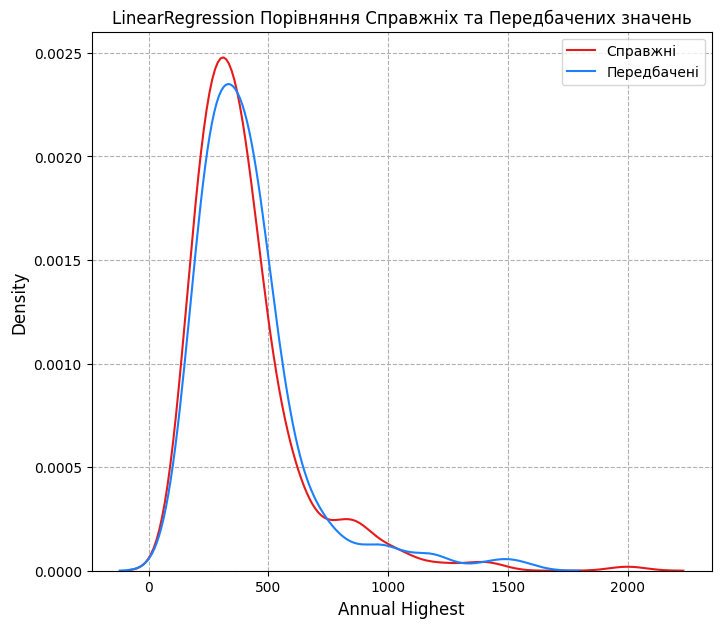

In [26]:
linear_model = LinearRegression().fit(x_train, y_train)

train_score = round(linear_model.score(x_train, y_train), 5)
test_score = round(linear_model.score(x_test, y_test), 5)
results.append({"Model": "Linear\nModel", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Linear\nModel", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_distribution_plot(linear_model, x_test, y_test)

# Lasso Regression

Train score: 0.71077.
Test score: 0.66554.


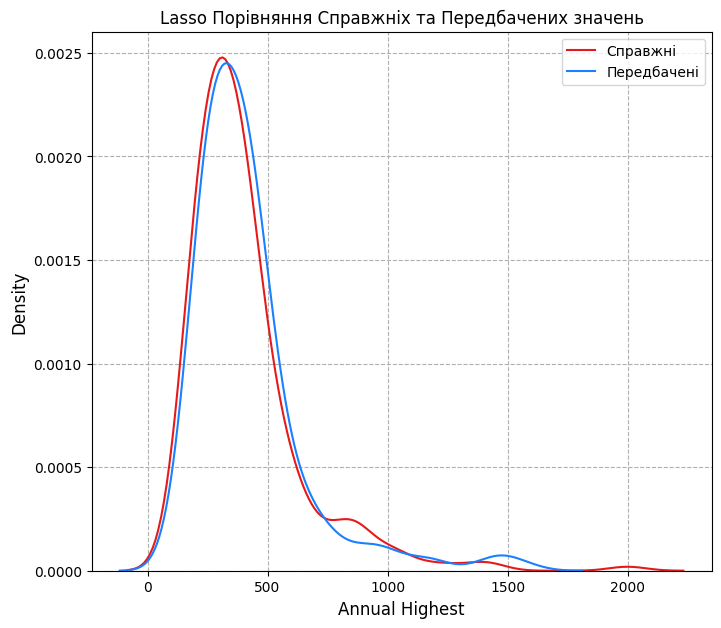

In [27]:
grid_search = GridSearchCV(Lasso(random_state = 0, max_iter = 50000), param_grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 1]}, cv = 5, verbose = 0 , n_jobs = 2).fit(x_train, y_train)

lasso_model = Lasso(alpha = grid_search.best_params_["alpha"], max_iter = 50000)
lasso_model.fit(x_train, y_train)

train_score = round(lasso_model.score(x_train, y_train), 5)
test_score = round(lasso_model.score(x_test, y_test), 5)
results.append({"Model": "Lasso\nModel", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Lasso\nModel", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_distribution_plot(lasso_model, x_test, y_test)

# Random Forest Regressor

Train score: 0.8403.
Test score: 0.64605.


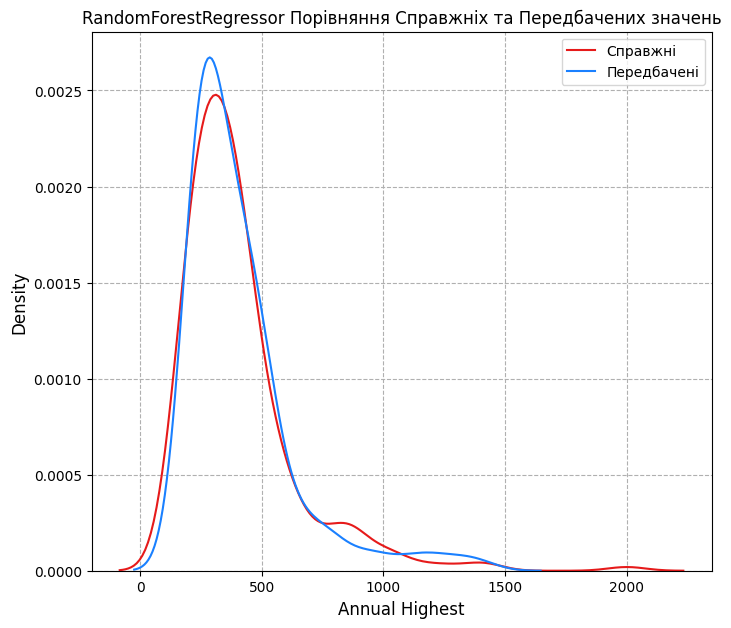

In [28]:
grid_search = GridSearchCV(RandomForestRegressor(random_state = 0, n_jobs = -2), { "n_estimators": [100, 200, 300], "max_depth": [2, 5, 10] }, cv = 5, verbose = 0).fit(x_train, y_train)
rf_model = RandomForestRegressor(random_state = 0, n_jobs = -2, **grid_search.best_params_)
rf_model.fit(x_train, y_train)

train_score = round(rf_model.score(x_train, y_train), 5)
test_score = round(rf_model.score(x_test, y_test), 5)
results.append({"Model": "Random\nForest\nRegressor", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Random\nForest\nRegressor", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_distribution_plot(rf_model, x_test, y_test)

# Gradient Boosting Regressor

Train score: 0.82145.
Test score: 0.65686.


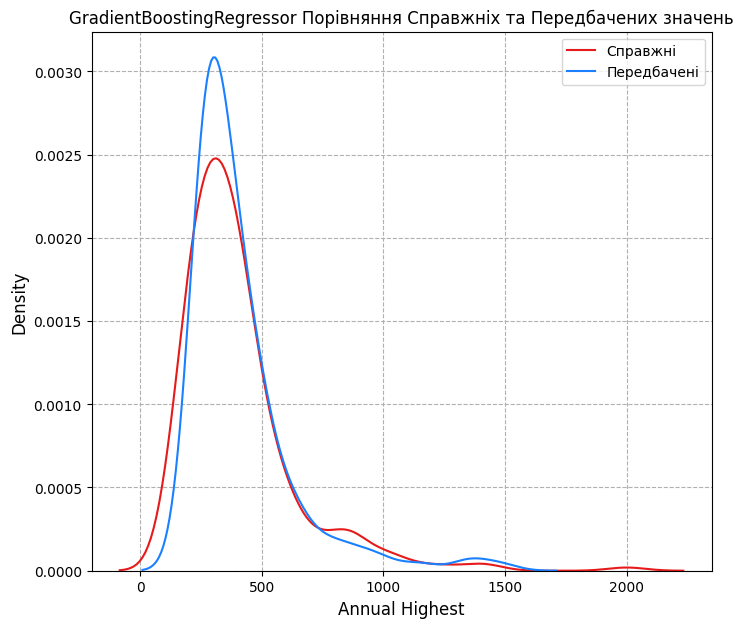

In [29]:
grid_search = GridSearchCV(GradientBoostingRegressor(random_state = 0), { "learning_rate": [0.1, 0.01, 0.001], "n_estimators": [100, 200, 300], "max_depth": [3, 5, 7] }, cv = 5, verbose = 0).fit(x_train, y_train)
gb_model = grid_search.best_estimator_.fit(x_train, y_train)

train_score = round(gb_model.score(x_train, y_train), 5)
test_score = round(gb_model.score(x_test, y_test), 5)
results.append({"Model": "Gradient\nBoosting\nRegressor", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Gradient\nBoosting\nRegressor", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_distribution_plot(gb_model, x_test, y_test)

# Гістограма порівняння результатів роботи моделей

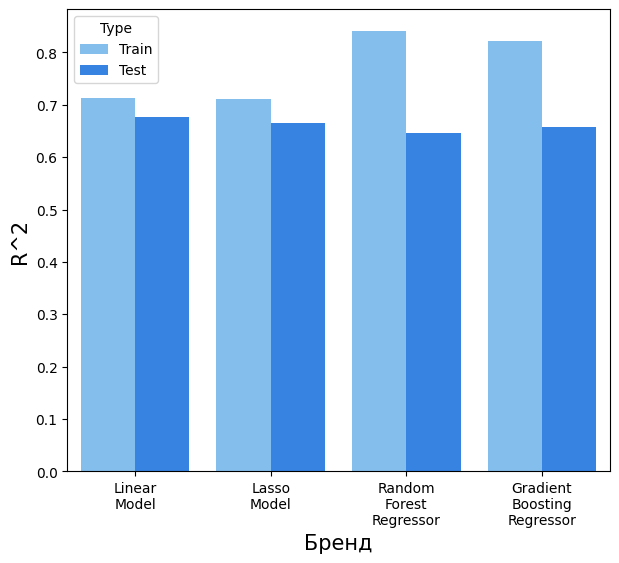

In [30]:
scores = pd.DataFrame(results, columns=["Model", "R^2 Score", "Type"])
plt.figure(figsize = (7, 6))
sns.barplot(x = "Model", y = "R^2 Score", hue = "Type", palette = [(0.45, 0.75, 1.0), (0.1, 0.5, 1.0)], data = scores)
plt.xlabel("Бренд", fontsize = 15)
plt.ylabel("R^2", fontsize = 15)
plt.show()